# Machine Learning for Trading - Random forest with Moving Averages as Predictor

In this paper we will be using 2 moving averages and use logistic regression to train our model.

From two moving average derives many different predicators, in this paper we will concentrated on 6:
1. Moving averages crossover
2. Moving averages crossover slope
3. Short moving average and price crossover
4. Long moving average and price crossover
5. Short Moving average slope
6. Long moving average slope

## Import Libraries

In [1]:
# Data Manupulation
import numpy as np
import pandas as pd

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

#Quandl
import quandl
quandl.ApiConfig.api_key = 'yKH7viSR-rMAAPPyhJ4C' # it is free for end of day data, you just need to create a user

## Load Data

SP500 from the January 1st,2010 to January 1st, 2018

In [2]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2018-01-01')
SP500 = quandl.get(["CHRIS/CME_SP1.1","CHRIS/CME_SP1.2","CHRIS/CME_SP1.3","CHRIS/CME_SP1.4"],start_date=start,end_date=end)#4 to keep only Last/CLose
SP500.columns = ['Open','High','Low','Close']
SP500 = SP500.dropna()

Text(0.5,1,'SP500 Close')

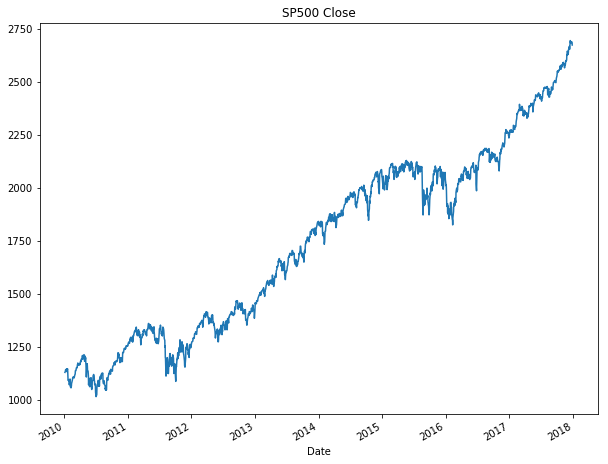

In [3]:
SP500['Close'].plot(figsize=(10,8))
plt.title('SP500 Close')

## Build Predictors

In [4]:
# sma 10
SP500['S_10'] = SP500['Close'].rolling(window=10).mean()/SP500['Close']*100#dividing by close normalise
# sma 10 slope
SP500['S_10_SL']=(SP500['S_10']- SP500['S_10'].shift(1))/SP500['S_10']*100
# sma 20
SP500['S_20'] = SP500['Close'].rolling(window=20).mean()/SP500['Close']*100
# sma 20 slope
SP500['S_20_SL']=(SP500['S_20']- SP500['S_20'].shift(1))/SP500['S_20']*100
#sma crossover
SP500['S_10_20_CO'] = np.where(SP500['S_10']>SP500['S_20'],1,-1)
#sma crossover slope
SP500['S_10_20_SL'] = (SP500['S_10'] - SP500['S_20'])/SP500['S_20']*100
#sma 10 - index crossover
SP500['S_10_IND_CO'] = np.where(SP500['Close']>SP500['S_10'],1,-1)
# sma 20 - index crossover
SP500['S_20_IND_CO'] = np.where(SP500['Close']>SP500['S_20'],1,-1)


In [5]:
SP500 = SP500.dropna()

In [6]:
SP500.tail(n=10)

,Open,High,Low,Close,S_10,S_10_SL,S_20,S_20_SL,S_10_20_CO,S_10_20_SL,S_10_IND_CO,S_20_IND_CO
Date,,,,,,,,,,,,
2017-12-14,2667.0,2668.0,2652.5,2652.8,99.808504,0.563699,98.962794,0.687023,1,0.854574,1,1
2017-12-18,2687.5,2697.6,2687.4,2694.0,98.467706,-1.361663,97.651633,-1.342692,1,0.835698,1,1
2017-12-19,2696.0,2697.9,2682.8,2684.3,98.994896,0.532543,98.205677,0.564167,1,0.803639,1,1
2017-12-20,2691.0,2695.2,2679.5,2681.7,99.290376,0.297591,98.486408,0.285045,1,0.816323,1,1
2017-12-21,2682.1,2695.5,2681.0,2688.0,99.275298,-0.015188,98.425781,-0.061596,1,0.863104,1,1
2017-12-22,2689.5,2691.3,2682.7,2686.2,99.514928,0.240799,98.662423,0.239850,1,0.864063,1,1
2017-12-26,2686.0,2688.9,2683.8,2687.2,99.612608,0.098060,98.787027,0.126135,1,0.835718,1,1
2017-12-27,2688.2,2690.5,2682.0,2685.2,99.773201,0.160958,99.016461,0.231712,1,0.764257,1,1
2017-12-28,2686.9,2689.0,2683.5,2685.5,99.838391,0.065296,99.117110,0.101546,1,0.727706,1,1


## Create predicator table

In [7]:
X = SP500[['S_10', 'S_10_SL','S_20','S_20_SL','S_10_20_CO','S_10_20_SL','S_10_IND_CO','S_20_IND_CO']]

In [8]:
X.head()

,S_10,S_10_SL,S_20,S_20_SL,S_10_20_CO,S_10_20_SL,S_10_IND_CO,S_20_IND_CO
Date,,,,,,,,
2010-02-03,99.470996,-0.271600,101.665907,-0.072316,-1,-2.158945,1,1
2010-02-04,102.256758,2.724282,104.652915,2.854205,-1,-2.289623,1,1
2010-02-05,102.145688,-0.108737,104.473957,-0.171294,-1,-2.228564,1,1
2010-02-08,102.175395,0.029075,104.454020,-0.019087,-1,-2.181462,1,1
2010-02-09,100.991371,-1.172401,103.087132,-1.325954,-1,-2.032999,1,1


## Create target variables

In [9]:
SP500['Side']= np.where(SP500['Close'].shift(-1)>SP500['Close'],1,-1)

In [10]:
Y = SP500['Side'].values 

## Splitting dataset 70% training 30% testing

In [15]:
split_percentage = 0.7
split = int(split_percentage*len(SP500))

X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

In [16]:
Y_train

array([-1, -1, -1, ...,  1, -1,  1])

In [17]:
RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RF.fit(X_train,Y_train)
accuracy_train = accuracy_score(Y_train,RF.predict(X_train))
accuracy_test = accuracy_score(Y_test,RF.predict(X_test))
print(accuracy_train)
print(accuracy_test)

0.981988472622
0.520134228188


The accuracy of the model is 98% with the training set and 52% with the testing set. That might suggest some overfitting.

## Create the trading strategy

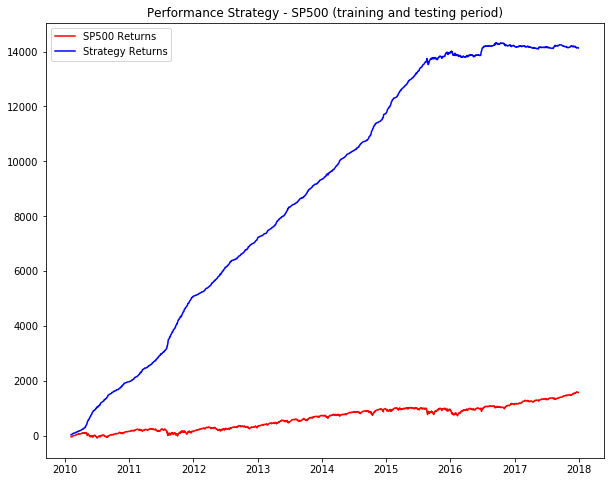

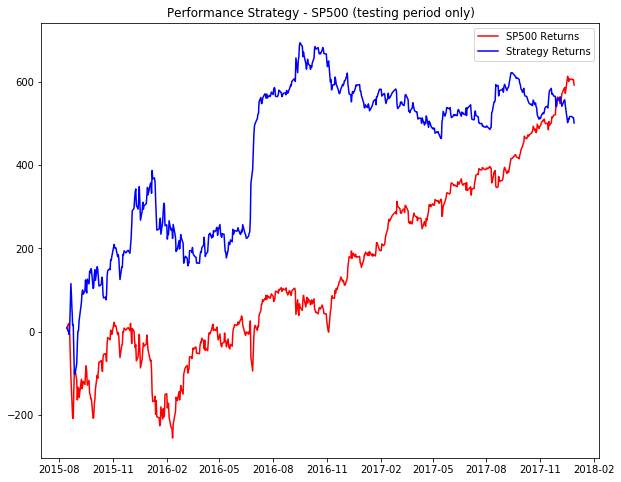

In [18]:
# predicted signals
SP500['Predicted_Signal']= RF.predict(X)

# compute SP and strategy returns total
SP500['SP_Returns'] = SP500['Close']-SP500['Close'].shift(1)
SP500['Strategy_Returns'] = SP500['SP_Returns'] * SP500['Predicted_Signal'].shift(1)
# compute SP and strategy returnson testing period
SP500test = SP500[split:]

# Strategy cumulative returns total
Cumulative_SP_Returns = SP500['SP_Returns'].cumsum()
Cumulative_Strat_Returns = SP500['Strategy_Returns'].cumsum()
# Strategy cumulative returns test
Cumulative_SP_Returns_test = SP500test['SP_Returns'].cumsum()
Cumulative_Strat_Returns_test = SP500test['Strategy_Returns'].cumsum()

# Plot the performance of SP500 and strategy total
plt.figure(figsize=(10,8))
plt.title('Performance Strategy - SP500 (training and testing period)')
plt.plot(Cumulative_SP_Returns,color='r',label='SP500 Returns')
plt.plot(Cumulative_Strat_Returns,color='b',label='Strategy Returns')
plt.legend()
plt.show()


# Plot the performance of SP500 and strategy test
plt.figure(figsize=(10,8))
plt.title('Performance Strategy - SP500 (testing period only)')
plt.plot(Cumulative_SP_Returns_test,color='r',label='SP500 Returns')
plt.plot(Cumulative_Strat_Returns_test,color='b',label='Strategy Returns')
plt.legend()
plt.show()